# Fine Tuning For BERT Models with TPU

## Import Library

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import average_precision_score
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import PrecisionRecallDisplay
from transformers import TFBertModel
from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization
from tensorflow.keras import Model
from official.nlp import optimization
from tensorflow.keras.metrics import Recall
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (18,6)
pd.set_option('display.max_columns', 50)
import tensorflow as tf
import os
!pip install -q tf-models-official
from official.nlp import optimization

In [4]:
# With this code, 8 TPU cores are allocated.
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [5]:
strategy = tf.distribute.TPUStrategy(resolver)#We allotted TPU cores to the strategy variable in order to benefit from their speed.


In [6]:
!pip install transformers #To use BERT models, we first need to install transformers.

### **Reading Data for Intent Classification**

The data contains various user queries categorized into seven

https://github.com/sonos/nlu-benchmark/tree/master/2017-06-custom-intent-enginesintents

In [7]:
df = pd.read_csv("/content/Womens Clothing E-Commerce Reviews.csv")#here, we read our data using the read_csv method.
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [8]:
df.info()# So here i will print the full summary of the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [9]:
print('df size :', df.shape)#I used shape method to represent the number of columns and rows .

df size : (23486, 11)


In [10]:
df=df.drop(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Rating'
       ,'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'], axis=1)# After infestegate in data, I drop unnessseory columns.

In [11]:
df #to show our dataset.

,Review Text,Recommended IND
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1
...,...,...
23481,I was very happy to snag this dress at such a ...,1
23482,"It reminds me of maternity clothes. soft, stre...",1
23483,"This fit well, but the top was very see throug...",0
23484,I bought this dress for a wedding i have this ...,1


In [12]:
df.duplicated().sum()# I used duplicated sum to determine whether or not our data had been duplicated.

850

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
df.duplicated().sum()# here, After infestegate i decided for removing duplicate data

0

In [15]:
print(df.isnull().sum())#I reviewed our data here for any missing values

Review Text        2
Recommended IND    0
dtype: int64


In [16]:
df.dropna(inplace=True)#SO here, i decided for removing missing values

In [17]:
df.isna().sum()

Review Text        0
Recommended IND    0
dtype: int64

In [18]:
df= df.rename(columns={"Recommended IND": "aim", "Review Text": "feedback"})# Here, I've renamed the columns to better fit the case.

In [19]:
df.head()# display our columns after renaming them

,feedback,aim
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [20]:
X = df['feedback']#split our data into x and y
y = df['aim']

In [21]:
y.head()

0    1
1    1
2    0
3    1
4    1
Name: aim, dtype: int64

In [22]:
#divided our data into x and y trains as well as x and y tests.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

### Tokenization Example For BERT

https://huggingface.co/bert-base-cased

https://huggingface.co/bert-base-uncased

In [23]:
tokenizer2 = BertTokenizer.from_pretrained('bert-base-uncased')# Here, i use the uncased model for classification and sentiment analysis problems.

In [24]:
print(len(tokenizer2.vocab))# There are 30522 unique tokens in BERT uncased model

30522


### Fixing token counts of all documents

In [25]:
# Here i will find out how many tokens the longest comment consists of and to decide on the number
# of tokens to fix for all documents/texts.
number_tokens_sentences = []
for sent in X:

    input_ids = tokenizer2.encode(sent, add_special_tokens=True)
    number_tokens_sentences.append(len(input_ids))

print('Max sentence length: ', max(number_tokens_sentences))

Max sentence length:  162


In [26]:
np.array(number_tokens_sentences).mean()# I looked up the amount tokens sentences average.

76.75947689316956

In [27]:
token_size = 162
sum(np.array(number_tokens_sentences) < token_size) / len(number_tokens_sentences)# We will fix all documents to size 162.

0.9999558186798622

### Transformation Vectors to Matrices

In [28]:
def transformation(X):
  # set array dimensions
  seq_len = 162

   # We create an empty list for input_ids vectors and an empty list for attention_mask vectors.
  Xids = []
  Xmask = []


  for text in X:

      tokens = tokenizer2.encode_plus(text, max_length=seq_len, truncation=True,
                                      padding='max_length', add_special_tokens=True)
      Xids.append(tokens['input_ids']) # We are appending the input_ids vectorto each document to the Xids list.
      Xmask.append(tokens['attention_mask']) # We are appending the attention_mask vector to each document to the Xmask list.


  return np.array(Xids), np.array(Xmask)# We are converting the Xids and Xmask matrices into array.

In [29]:
# Here , i create two separate matrices for our training set and test set.
Xids_train, Xmask_train = transformation(X_train)
Xids_test, Xmask_test = transformation(X_test)

In [30]:
# print shape for training set and test set.
print("Xids_train.shape  :", Xids_train.shape)
print("Xmask_train.shape :", Xmask_train.shape)
print("Xids_test.shape   :", Xids_test.shape)
print("Xmask_test.shape  :", Xmask_test.shape)

Xids_train.shape  : (20370, 162)
Xmask_train.shape : (20370, 162)
Xids_test.shape   : (2264, 162)
Xmask_test.shape  : (2264, 162)


In [31]:
labels_train = y_train.values.reshape(-1,1)#Here, we choose to reshape the train and the test to make them appropriate for transferring.

In [32]:
labels_train

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [33]:
labels_test = y_test.values.reshape(-1,1)#Here, we choose to reshape the train and the test to make them appropriate for transferring.

In [34]:
labels_test

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

## Transformation Matrix to Tenserflow Tensor

In [35]:
#The last step is to turn the matrices we got previously into grouped TensorFlow tensors before feeding the data into BERT models.
dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_train

<_TensorSliceDataset element_spec=(TensorSpec(shape=(162,), dtype=tf.int64, name=None), TensorSpec(shape=(162,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [36]:
#The last step is to turn the matrices we got previously into grouped TensorFlow tensors before feeding the data into BERT models.
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))
dataset_test

<_TensorSliceDataset element_spec=(TensorSpec(shape=(162,), dtype=tf.int64, name=None), TensorSpec(shape=(162,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [37]:
# we convert our three-item tuple into a two-item tuple where the input item is a dictionary
def map_func(Tensor_Xids, Tensor_Xmask, Tensor_labels):
    return {'input_ids': Tensor_Xids, 'attention_mask': Tensor_Xmask}, Tensor_labels

In [38]:
# Finally, to apply this transformation, we utilize the dataset map technique.
dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)

In [39]:
dataset_train

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(162,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(162,), dtype=tf.int64, name=None)}, TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [40]:
dataset_test

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(162,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(162,), dtype=tf.int64, name=None)}, TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

## Batch Size Train and Validation Dataset

In [41]:
batch_size = 43# Here, the batch size was specified.

train_ds = dataset_train.batch(batch_size)
val_ds = dataset_test.batch(batch_size)

In [42]:
train_ds

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 162), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 162), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [44]:
#We are creating an optimization method here
epochs = 1
steps_per_epoch = len(train_ds)

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5
optimizer= optimization.create_optimizer(init_lr=init_lr,num_train_steps=num_train_steps,num_warmup_steps=num_warmup_steps,optimizer_type='adamw')

## Creating Model

In [45]:
 #we began developing our model using a certain parameter.
 def create_model():
    from transformers import TFBertModel
    from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization
    from tensorflow.keras import Model

    model = TFBertModel.from_pretrained("bert-base-uncased")


    input_ids = Input(shape=(162,), name='input_ids', dtype='int32')
    attention_mask = Input(shape=(162,), name='attention_mask', dtype='int32')


    embeddings = model.bert(input_ids=input_ids, attention_mask=attention_mask)["pooler_output"] #[1]


    x = Dense(160, activation='relu')(embeddings) # We are reducing the dimensionality to 160.
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    y = Dense(1, activation='sigmoid', name='outputs')(x) #

    return Model(inputs=[input_ids, attention_mask], outputs=y)


In [46]:
# Before fitting the model, we compile the model.
with strategy.scope():
  optimizer = optimizer
  loss = tf.keras.losses.BinaryCrossentropy()
  recall = tf.keras.metrics.Recall()
  modely = create_model()
  modely.compile(optimizer=optimizer, loss=loss, metrics=[recall])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [47]:
modely.summary()#thus we've printed a summary of our model here.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 162)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 162)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 162, 7                                       

In [48]:
modely.fit(train_ds, validation_data= val_ds,epochs=epochs)# we fitted our model.

474/474 [==============================] - 209s 252ms/step - loss: 0.5635 - recall: 0.7763 - val_loss: 0.4463 - val_recall: 0.9342


## Model evaluation

In [49]:
y_pred = modely.predict(val_ds) >= 0.5# Here we print classification_report for test set

print(classification_report(y_test, y_pred))

53/53 [==============================] - 29s 238ms/step
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       410
           1       0.96      0.93      0.95      1854

    accuracy                           0.92      2264
   macro avg       0.85      0.88      0.86      2264
weighted avg       0.92      0.92      0.92      2264



In [50]:
y_train_pred = modely.predict(train_ds) >= 0.5# Here we print classification_report for train set

print(classification_report(y_train, y_train_pred))

474/474 [==============================] - 21s 39ms/step
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      3690
           1       0.97      0.95      0.96     16680

    accuracy                           0.93     20370
   macro avg       0.88      0.90      0.89     20370
weighted avg       0.93      0.93      0.93     20370



53/53 [==============================] - 6s 47ms/step


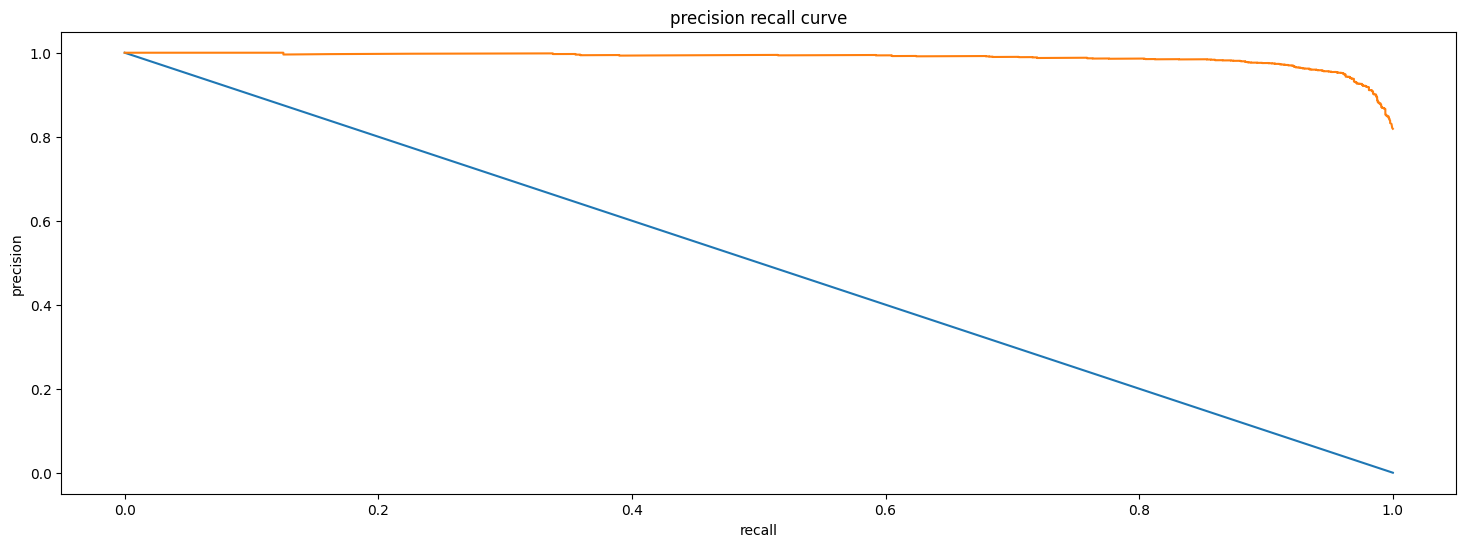

In [51]:
# we plot our model
y_pred_proba = modely.predict(val_ds)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot([1,0],[0,1],'')
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision recall curve')
plt.show()

In [52]:
average_precision_score(y_test, y_pred_proba)# here we calc average precision score

0.9881367321663608

In [57]:
BERT_with_AP = average_precision_score(y_test, y_pred_proba)# Review the performance model and select the optimal model
BERT_with_f1 = f1_score(y_test, y_pred)
BERT_with_rec = recall_score(y_test, y_pred)

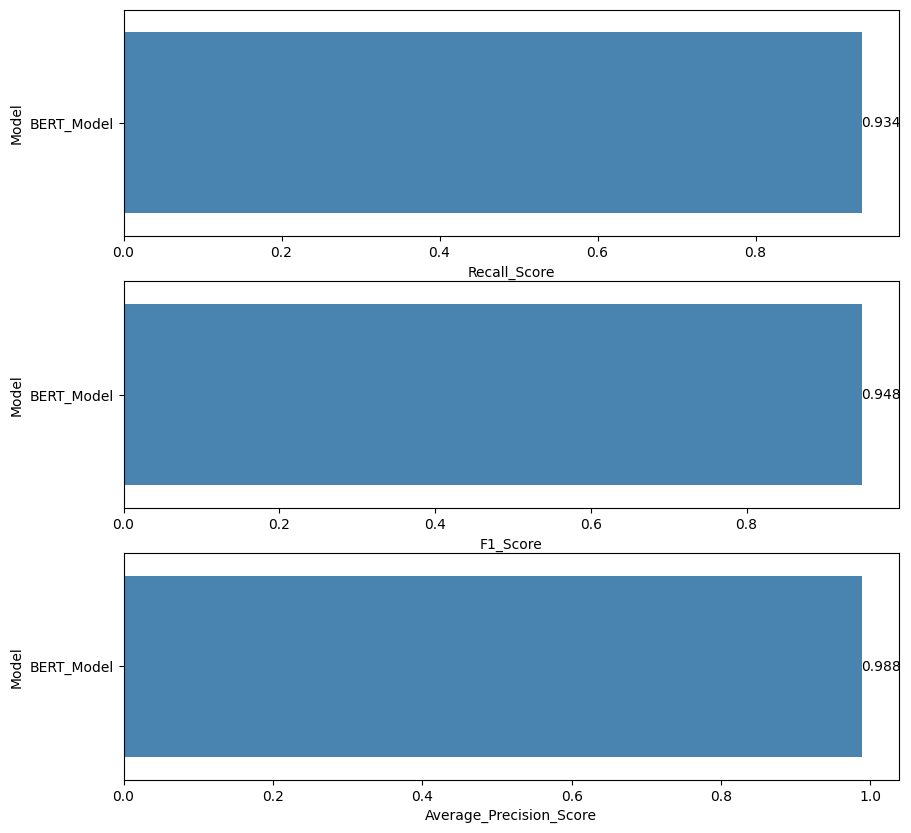

In [66]:
compare = pd.DataFrame({"Model": [ "BERT_Model"],

                        "F1_Score": [BERT_with_f1],

                        "Recall_Score": [BERT_with_rec],

                        "Average_Precision_Score": [BERT_with_AP]})

plt.figure(figsize=(10,10))
plt.subplot(311)
compare = compare.sort_values(by="Recall_Score",
                              ascending=False)
ax=sns.barplot(x="Recall_Score",
               y="Model",
               data=compare,
               palette="Blues_d")
ax.bar_label(ax.containers[0], fmt="%.3f")

plt.subplot(312)
compare = compare.sort_values(by="F1_Score",
                              ascending=False)
ax=sns.barplot(x="F1_Score",
               y="Model",
               data=compare,
               palette="Blues_d")
ax.bar_label(ax.containers[0], fmt="%.3f")


plt.subplot(313)
compare = compare.sort_values(by="Average_Precision_Score",
                              ascending=False)
ax=sns.barplot(x="Average_Precision_Score",
               y="Model",
               data=compare,
               palette="Blues_d")
ax.bar_label(ax.containers[0], fmt="%.3f")
plt.show();

In [ ]:
### Conclusion

In [ ]:
Thus, after investigating every performance model, we determine that BERT Models with TPU is the best model to handle our NLP Sentiment Analysis problem.